In [1]:
import numpy as np
import torch
import torch.nn as nn

from pfi.utils import load_data, X_from_snapshots, SpectralNormDNN, DNN
from pfi.score import ScoreMatching
from pfi.flow import FlowRegression
from pfi.flow.models import CLEFlow
from pfi.flow.interpolants import ChebyshevInterpolant

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


/mnt/home/vchardes/.local/share/venvs/score/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


device(type='cuda')

In [20]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

nsamples = 6000
Np = 150
Nf = 150
L = 5
fac = 4
nmb = 4
lx = 0.7

# Use longer runs to align with MultiStepLR milestones used in the solvers
score_epochs = 11000
flow_epochs = 9000


In [21]:
path = '/mnt/home/vchardes/ceph/datasets/HSC_data/10XChromiumV3_10.1038_s41467-021-27159-x_10.5281_zenodo.5291737_exvivo.h5ad'
genes = ['fli1', 'klf1', 'gata1', 'gata2', 'gfi1b', 'runx1', 'tal1', 'jun', 'spi1', 'zfpm1', 'lmo2', 'etv6', 'erg', 'mef2c']

samples, times, ind_array, cell_types = load_data(
    path=path,
    nsamples=nsamples,
    genes=genes,
    time_key='day',
    cell_type_key='cell_type',
    seed=seed,
)

X = X_from_snapshots([samples[k] for k in range(samples.shape[0])], times)
ndim = X.shape[1] - 1
print('X shape:', X.shape, 'ndim:', ndim, 'times:', times)


X shape: (36000, 15) ndim: 14 times: [ 0  2  4  6  8 11]


In [22]:
score_model = DNN(
    sizes=[ndim + 2, Np, Np, Np, Np, Np, ndim],
    activation=nn.ELU(),
).to(device)

score_reg = ScoreMatching(
    model=score_model,
    solver='dsm',
    solver_kwargs=dict(L=L, 
                       lr=1e-2, 
                       n_epochs=score_epochs, 
                       bs=nsamples, 
                       adp_flag=1),
    device=device,
)
score_reg.fit(X)


/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain = torch.tensor(x_train, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xdata = torch.tensor(x_data, dtype=torch.float32).to(device)
DSM:   0%|          | 8/11000 [00:00<05:50, 31.37it/s, lo

epoch: 0 c_: [0.16149011 0.16479315 0.16389608 0.16784753 0.17056194 0.17141111]


DSM:   5%|▍         | 505/11000 [00:15<05:30, 31.71it/s, loss=1.207e+00, lr=1.00e-02]

epoch: 500 c_: [0.14447854 0.15220977 0.17093341 0.19469579 0.18820791 0.14947458]


DSM:   9%|▉         | 1010/11000 [00:30<04:25, 37.63it/s, loss=1.079e+00, lr=1.00e-02]

epoch: 1000 c_: [0.1149564  0.17471504 0.17086017 0.1904367  0.18994813 0.15908352]


DSM:  14%|█▎        | 1508/11000 [00:46<04:24, 35.86it/s, loss=1.095e+00, lr=1.00e-02]

epoch: 1500 c_: [0.08662314 0.12525982 0.18322861 0.21604326 0.21089569 0.1779495 ]


DSM:  18%|█▊        | 2005/11000 [01:01<04:44, 31.61it/s, loss=1.050e+00, lr=1.00e-02]

epoch: 2000 c_: [0.09830665 0.130037   0.18491521 0.20625408 0.20401792 0.17646912]


DSM:  23%|██▎       | 2510/11000 [01:16<03:46, 37.45it/s, loss=9.439e-01, lr=1.00e-03]

epoch: 2500 c_: [0.2661112  0.18204708 0.14794327 0.14448586 0.13965558 0.119757  ]


DSM:  27%|██▋       | 3008/11000 [01:31<03:43, 35.80it/s, loss=9.667e-01, lr=1.00e-03]

epoch: 3000 c_: [0.2223421  0.06088576 0.10106954 0.27911308 0.16420397 0.1723856 ]


DSM:  32%|███▏      | 3505/11000 [01:47<03:57, 31.57it/s, loss=9.583e-01, lr=1.00e-03]

epoch: 3500 c_: [0.23340084 0.05191413 0.09372934 0.29138008 0.14412732 0.18544835]


DSM:  36%|███▋      | 4010/11000 [02:02<03:06, 37.49it/s, loss=9.467e-01, lr=1.00e-03]

epoch: 4000 c_: [0.24129228 0.04531543 0.0859154  0.28942496 0.12800552 0.2100464 ]


DSM:  41%|████      | 4508/11000 [02:17<03:01, 35.76it/s, loss=9.336e-01, lr=1.00e-03]

epoch: 4500 c_: [0.1571679  0.08406153 0.12916064 0.2387856  0.18333611 0.20748824]


DSM:  46%|████▌     | 5005/11000 [02:32<03:09, 31.58it/s, loss=9.140e-01, lr=1.00e-03]

epoch: 5000 c_: [0.15794334 0.08715565 0.1132508  0.2663227  0.15417217 0.22115529]


DSM:  50%|█████     | 5510/11000 [02:48<02:25, 37.65it/s, loss=9.015e-01, lr=1.00e-03]

epoch: 5500 c_: [0.10729337 0.12788247 0.19709012 0.20672005 0.18856394 0.1724501 ]


DSM:  55%|█████▍    | 6008/11000 [03:03<02:18, 36.03it/s, loss=8.889e-01, lr=1.00e-03]

epoch: 6000 c_: [0.15307108 0.10856819 0.15928923 0.2343369  0.16701221 0.1777224 ]


DSM:  59%|█████▉    | 6505/11000 [03:18<02:21, 31.73it/s, loss=8.800e-01, lr=1.00e-04]

epoch: 6500 c_: [0.1291554  0.12512219 0.1878996  0.19605717 0.18681917 0.17494649]


DSM:  64%|██████▎   | 7010/11000 [03:33<01:45, 37.65it/s, loss=8.794e-01, lr=1.00e-04]

epoch: 7000 c_: [0.3115625  0.0384659  0.06823047 0.24300833 0.08903524 0.24969755]


DSM:  68%|██████▊   | 7508/11000 [03:49<01:37, 35.84it/s, loss=8.772e-01, lr=1.00e-04]

epoch: 7500 c_: [0.31718746 0.03614593 0.06469918 0.23358986 0.08759031 0.26078722]


DSM:  73%|███████▎  | 8005/11000 [04:04<01:34, 31.56it/s, loss=8.751e-01, lr=1.00e-04]

epoch: 8000 c_: [0.31898302 0.03481396 0.06251229 0.22512694 0.08632359 0.27224016]


DSM:  77%|███████▋  | 8510/11000 [04:19<01:06, 37.63it/s, loss=8.727e-01, lr=1.00e-05]

epoch: 8500 c_: [0.31997535 0.03383306 0.06071871 0.21796048 0.0850745  0.28243795]


DSM:  82%|████████▏ | 9008/11000 [04:34<00:55, 35.66it/s, loss=8.724e-01, lr=1.00e-05]

epoch: 9000 c_: [0.32028568 0.03371572 0.06049344 0.21704201 0.08488909 0.28357404]


DSM:  86%|████████▋ | 9505/11000 [04:50<00:47, 31.59it/s, loss=8.720e-01, lr=1.00e-05]

epoch: 9500 c_: [0.32043016 0.03359532 0.06025936 0.2161742  0.0847199  0.28482103]


DSM:  91%|█████████ | 10010/11000 [05:05<00:26, 37.45it/s, loss=8.716e-01, lr=1.00e-05]

epoch: 10000 c_: [0.32070956 0.03345116 0.05997101 0.2151101  0.0845136  0.28624457]


DSM:  96%|█████████▌| 10508/11000 [05:20<00:13, 35.95it/s, loss=8.710e-01, lr=1.00e-05]

epoch: 10500 c_: [0.32117045 0.03328076 0.05963163 0.21383356 0.08426415 0.28781945]


DSM: 100%|██████████| 11000/11000 [05:35<00:00, 32.79it/s, loss=8.702e-01, lr=1.00e-05]


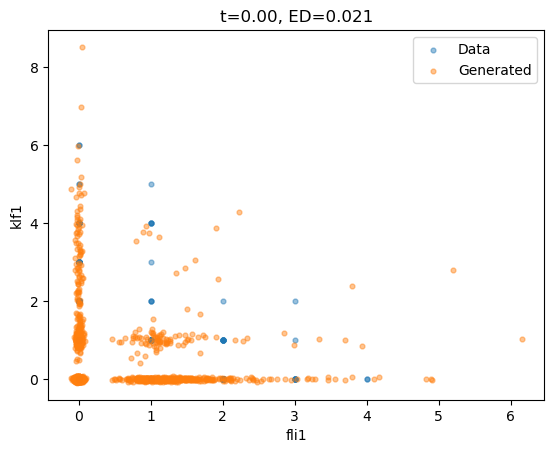

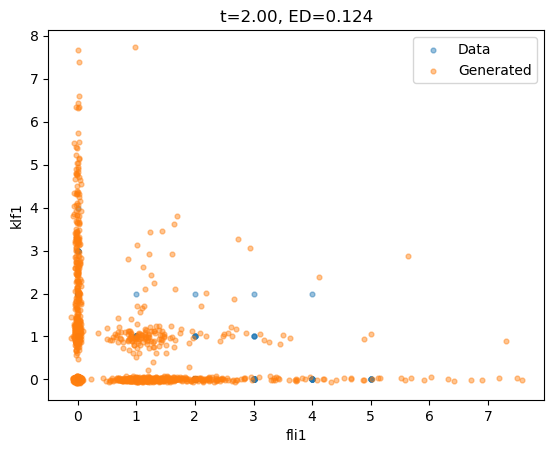

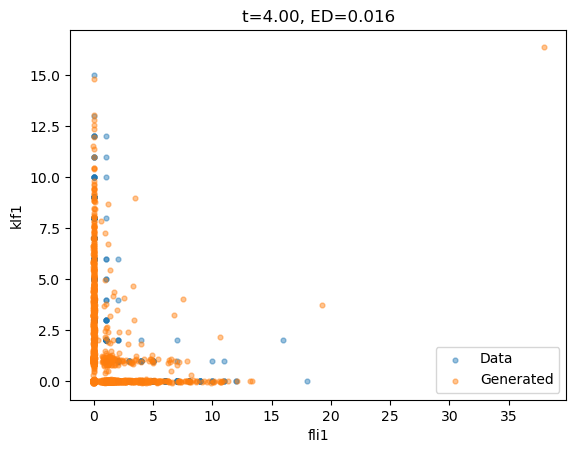

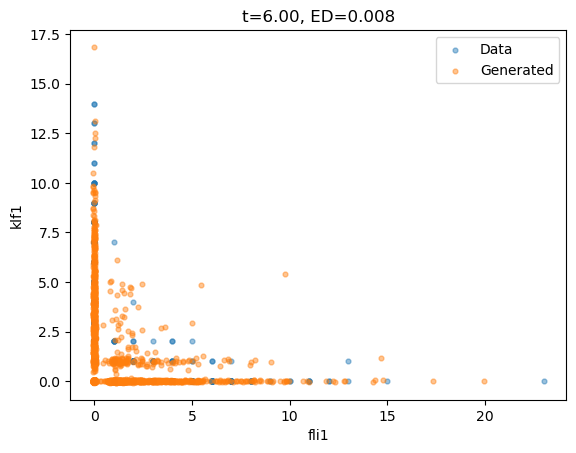

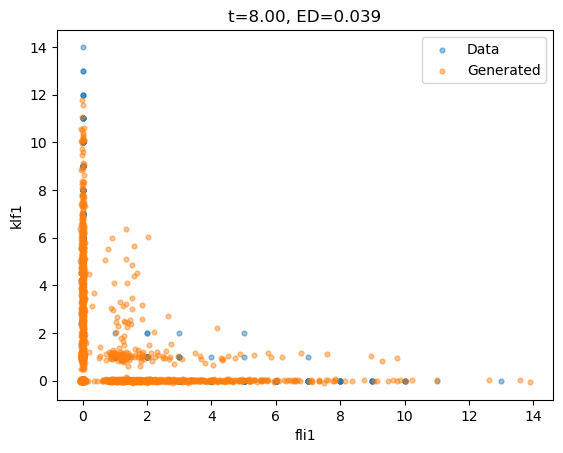

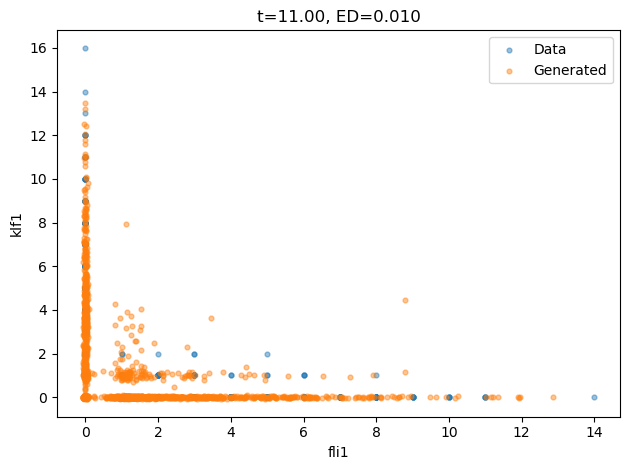

ED per time: [0.02106285 0.12399197 0.01615524 0.00846195 0.03902149 0.00998116]


In [25]:
# Validate score model: generated samples vs observed snapshots + ED
import matplotlib.pyplot as plt

times_eval = np.unique(X[:, -1])
ed_score = score_reg.score(X, maxiter=100)

ncols = min(4, len(times_eval))
nrows = int(np.ceil(len(times_eval) / ncols))
#fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))

for k, t in enumerate(times_eval):

    fig, ax = plt.subplots()
    xk = X[X[:, -1] == t][:2000]
    gen = score_reg.sample(xk, nsamples=xk.shape[0], maxiter=100)

    ax.scatter(xk[:, 0], xk[:, 1], s=12, alpha=0.45, label='Data')
    ax.scatter(gen[:, 0], gen[:, 1], s=12, alpha=0.45, label='Generated')
    ax.set_title(f't={t:.2f}, ED={ed_score[k]:.3f}')
    ax.set_xlabel(genes[0])
    ax.set_ylabel(genes[1])
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

print('ED per time:', ed_score)


In [26]:
drift_model = SpectralNormDNN(
    sizes=[ndim, Nf, Nf, Nf, Nf, ndim],
    activation=nn.ELU(),
).to(device)

cle_model = CLEFlow(
    net=drift_model,
    score=score_reg.model_,
    Ndim=ndim,
    lx=lx,
)

flow_reg = FlowRegression(
    interp=ChebyshevInterpolant(device=device),
    model=cle_model,
    growth_model=None,
    solver='fm',
    solver_kwargs=dict(fac=fac, 
                       nb=nmb, 
                       n_epochs=flow_epochs, 
                       lr=1e-2),
    device=device,
)
flow_reg.fit(X)


6000 1500
[lambda-selection] Initial error: 0.1729
[lambda-selection] Best lambda (>=80% drop): 0.8000
[lambda-selection] Vel magnitudes: [0.17293137 0.16221143 0.15339689 0.1427277  0.12202394 0.10223816
 0.09020897 0.08176845 0.06234175 0.0518821  0.04502926 0.04011296
 0.03108128 0.02744925]


FM:   0%|          | 0/9000 [00:00<?, ?it/s]/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:291: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Dist = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights, dtype=torch.float32, device=device)
FM:   0%|          | 1/9000 [00:00<24:09,  6.21it/s, loss=6.986e+00, lr=1.00e-02]

[epoch 0] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:   6%|▌         | 503/9000 [00:26<07:32, 18.79it/s, loss=1.168e+00, lr=1.00e-02]

[epoch 500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  11%|█         | 1003/9000 [00:53<07:04, 18.85it/s, loss=6.466e-01, lr=1.00e-03]

[epoch 1000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  17%|█▋        | 1503/9000 [01:19<06:38, 18.82it/s, loss=6.163e-01, lr=1.00e-04]

[epoch 1500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  22%|██▏       | 2003/9000 [01:46<06:11, 18.84it/s, loss=5.817e-01, lr=1.00e-04]

[epoch 2000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  28%|██▊       | 2503/9000 [02:12<05:45, 18.79it/s, loss=6.093e-01, lr=1.00e-04]

[epoch 2500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  33%|███▎      | 3003/9000 [02:38<05:19, 18.75it/s, loss=5.927e-01, lr=1.00e-04]

[epoch 3000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  39%|███▉      | 3503/9000 [03:05<04:52, 18.80it/s, loss=6.057e-01, lr=1.00e-04]

[epoch 3500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  44%|████▍     | 4003/9000 [03:31<04:26, 18.74it/s, loss=5.781e-01, lr=1.00e-04]

[epoch 4000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  50%|█████     | 4503/9000 [03:58<03:59, 18.81it/s, loss=5.852e-01, lr=1.00e-04]

[epoch 4500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  56%|█████▌    | 5003/9000 [04:24<03:32, 18.84it/s, loss=5.795e-01, lr=1.00e-04]

[epoch 5000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  61%|██████    | 5503/9000 [04:51<03:06, 18.79it/s, loss=6.219e-01, lr=1.00e-04]

[epoch 5500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  67%|██████▋   | 6003/9000 [05:17<02:39, 18.79it/s, loss=5.919e-01, lr=1.00e-04]

[epoch 6000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  72%|███████▏  | 6503/9000 [05:44<02:12, 18.82it/s, loss=5.893e-01, lr=1.00e-04]

[epoch 6500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  78%|███████▊  | 7003/9000 [06:10<01:46, 18.82it/s, loss=5.728e-01, lr=1.00e-04]

[epoch 7000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  83%|████████▎ | 7503/9000 [06:37<01:19, 18.80it/s, loss=5.827e-01, lr=1.00e-04]

[epoch 7500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  89%|████████▉ | 8003/9000 [07:03<00:53, 18.79it/s, loss=5.886e-01, lr=1.00e-05]

[epoch 8000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  94%|█████████▍| 8503/9000 [07:29<00:26, 18.76it/s, loss=5.542e-01, lr=1.00e-05]

[epoch 8500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 9000/9000 [07:56<00:00, 18.90it/s, loss=5.816e-01, lr=1.00e-05]


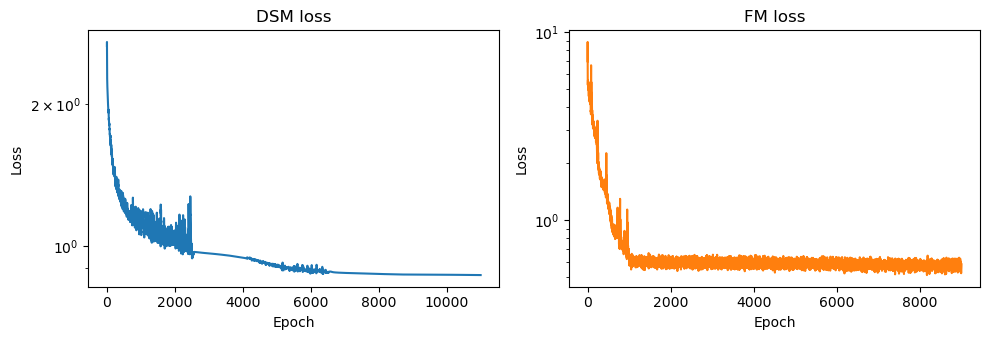

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0].plot(score_reg.loss_, lw=1.5)
ax[0].set_title('DSM loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')

ax[1].plot(flow_reg.loss_, lw=1.5, color='tab:orange')
ax[1].set_title('FM loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')

plt.tight_layout()
plt.show()
